<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Ivan Andres Arellano Ruelas, Jesus Ivan Lafarga Lizarraga

**Fecha:** 13 de octubre del 2021.

**Expediente** : IF708989, IF714383.
**Profesor:** Oscar David Jaramillo Zuluaga.
    
**Link Github**: https://github.com/IvanArellanoRuelas/ProyectoModulo1_ArellanoI_LafargaI

# Proyecto TEMA-2

## **1. Introducción:**



### 1.1 Predicción de nivel de tarjeta de crédito
> En base a la información financiera de miles de personas, se determinará que nivel de tarjeta debe recibir esa persona, haciendo que cada una tenga el servicio que espera de una tarjeta de crédito. Esto es de gran utilidad ya que ayuda mucho a la relación que tiene el cliente con el banco, lo que se podría reflejar en que el usuario se mantenga como usuario muchos años, si se le asigna la tarjeta de crédito correcta 

### 1.2 Objetivos: 

> **Objetivo general:**
 * Asignar el nivel correctro de asignación de tarjeta de crédito de un cliente en base a su información financiera 
 
 
> **Objetivos especificos**
 * Simular el limite de crédito de cada cliente
 * Simular el porcetaje de crédito que utilizara cada cliente 
 * Simuñar el ingreso Anual de cada cliente
 * Simular los meses de relación que se tiene con el banco 
 * Determinar las distribucciones de nuestros nodos para ver cual es la cantidad de ingreso con la que cuentan los usuarios de este banco

### 1.3 Definición del problema.


> Es de suma importancia conocer el comportamiento que tienen los clientes de un banco sobre la comodidad de sus tarjetas de crédito, para brindar un mejor servicio al cliente se generará una simulación para llevar un control más cercano a la comodidad del cliente en relación a la tarjeta y el crédito correcto a cada cliente en base a su información. 

> Para cada usuario en base a los de datos de información registrados por medio de simulaciones se le da un nivel correcto de rango y un crédito adecuado, teniendo en cuenta que el banco requiere que el promedio de uso de crédito de cada tarjeta ronde el 50%

### 1.4 Nodos 
1. Simular crédito correcto de cada cliente. 
2. Saber que porcentaje de su crédito gastara 
3. Simular el número de meses de relación que se tiene con el banco 
4. Simular su ingreso anual 


### 1.5 Hipotesis y supuestos 
> Existe una fuerte correlación entre varias variables, que nos permitirá llegar al objetivo de manera optima.
Un ejemplo de esto es la correlación que vemos entre las variables de rango de salario, su nivel de estudios y si tiene o no dependientes. 

> Suponemos que las distribucciones de créditos en los bancos se comporta con una forma logaritmica o parecida 

> Los meses de relación que tiene un cliente con el banco tiene una relación con el crédito aprobado que maneja 

> El crédito aprobado tambien tiene un distribucón logaritmica 


> A menor crédito mayor uso de la cantidad total del mismo, créditos pequeños usaran un porcentaje mayor del capital otorgado a los de créditos de grandes cantidades.





### 1.6 obtención de bases de datos 
> La base de datos se obtuvo de la plataforma kaggle la cual tiene bases de datos de libre acceso, contamos con más de 10,000 usuarios de tarjetas de crédito, de un banco en la cual los usuarios pueden descargar la información para el manejo de datos. 
Conocemos que el banco ha tenido problemas por medio de la descripción que proporciona la página, debido a que el banco no ha podido definir a que clientes darle una mejor atención, por lo cual es vital hacer un análisis para saber que categoría de servicio( Tarjeta de crédito) debe recibir cada usuario .

> Credit Card customers. (2020, 19 noviembre). Kaggle. https://www.kaggle.com/sakshigoyal7/credit-card-customers

# 1.7 Visualización de resultados de simulación.
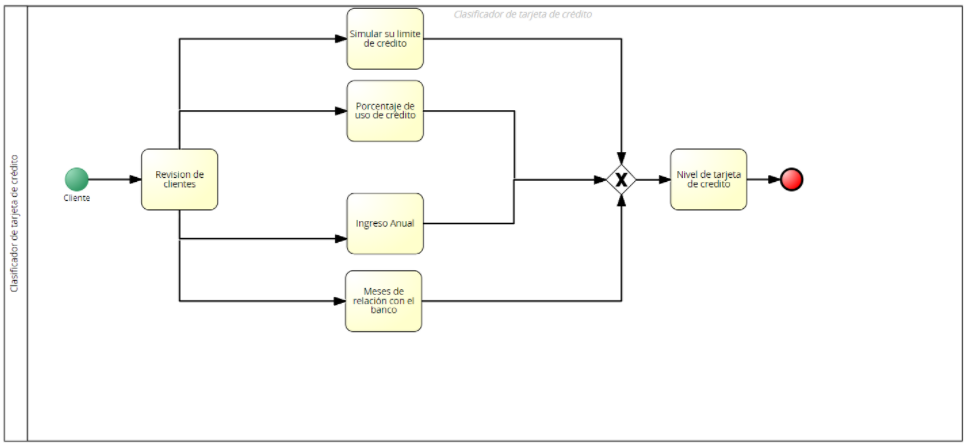

## 1.6  Obtención de bases de datos

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import scipy.stats as st
import statsmodels.api as sm 
from sklearn.model_selection import GridSearchCV
import warnings 
warnings.filterwarnings("ignore")
db = pd.read_csv('BankChurners.csv',skiprows=2)
db.head(10)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Income_Category1,Income_Category2
0,789081408,Attrited Customer,44,F,4,Uneducated,Single,Less than $40K,Blue,32,...,1438.3,170,1268.3,0.889,2527,45,0.406,0.118,1,1.218404
1,718939083,Attrited Customer,54,F,2,Graduate,Married,Less than $40K,Blue,45,...,1438.3,306,1132.3,1.035,694,15,0.364,0.213,1,1.200982
2,806256333,Attrited Customer,41,M,4,Graduate,Unknown,$60K - $80K,Blue,36,...,1438.3,312,1126.3,0.657,1786,26,0.733,0.217,2,2.380492
3,713474733,Attrited Customer,51,M,2,Graduate,Single,$80K - $120K,Blue,31,...,1438.3,327,1111.3,0.528,1783,40,0.481,0.227,3,3.767776
4,718675158,Attrited Customer,55,F,1,Unknown,Married,Less than $40K,Blue,36,...,1438.3,361,1077.3,0.963,850,22,0.692,0.251,1,1.311521
5,710525508,Attrited Customer,48,F,2,High School,Married,Less than $40K,Blue,36,...,1438.3,455,983.3,0.626,2090,50,0.562,0.316,1,1.029844
6,711588708,Attrited Customer,50,F,2,Uneducated,Married,$40K - $60K,Blue,36,...,1438.3,458,980.3,0.613,1863,42,0.312,0.318,0,0.500530
7,717865008,Existing Customer,51,F,1,Unknown,Married,$40K - $60K,Blue,36,...,1438.3,468,970.3,0.747,4425,81,1.077,0.325,0,0.862526
8,714495258,Existing Customer,26,M,0,College,Single,Less than $40K,Blue,36,...,1438.3,479,959.3,0.553,1786,37,0.370,0.333,1,1.733157
9,710723958,Existing Customer,43,F,3,Uneducated,Single,Unknown,Blue,32,...,1438.3,491,947.3,0.494,5016,86,0.593,0.341,0,0.311097


# Funciones en el código: 


In [2]:
# Funciones que se van a usar en el siguiente proyecto

def kde_sklearn(x, x_grid, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)


def generador_var(proba_acum: 'Probabilidad acumulada', indices: 'Valores por generar', N: 'Aleatorios por generar'):
    diccionario = {i: idx for i, idx in enumerate(indices)}
    U = np.random.rand(N)
    y = pd.Series([sum([1 for p in proba_acum if p < ui]) for ui in U]).map(diccionario)
    return y


def kde_sklearn_mod(x, bandwidth, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    pdf = lambda x_grid: np.exp(kde_skl.score_samples(x_grid[:, np.newaxis])) if isinstance(x_grid, np.ndarray) else \
        np.exp(kde_skl.score_samples(np.array[x_grid])[:, np.newaxis])
    return pdf


def muestreo_est(B: 'Número de estratos'):
    u= np.random.uniform(B) 
    i=np.arange(0,B) 
    v = (u+i)/B 
    return v 
   
def prueba_dist(nodo: "Nodo", bins: 'bins'):
    '''
    Nos devuelve distribuciones continuas (15) , para poder observar cual se adapta mejor a nuestro nodo
    '''
    d_continuas = [d for d in dir(st) if isinstance(getattr(st, d), getattr(st, "rv_continuous"))]

    y, x, _ = plt.hist(nodo, bins=bins, density=True)
    x = x[1:]

    error = pd.DataFrame(columns = ["distribución", "error"])
    i = 0

    for d in d_continuas[5:20]:
        try:
            params = getattr(st, d).fit(nodo)
            y_hat = getattr(st, d)(*params).pdf(x)
            error.loc[i, :] = [d, np.mean(np.abs((y - y_hat)/y))] #Error MAPE
            plt.plot(x, y_hat, label = d)
            i += 1
        except:
            pass
    plt.legend()
    plt.show()
    

    error.set_index("distribución", inplace=True)
    print(error.sort_values("error"))  
    
    

# Función que hace la prueba Q_Q y nos muestra la gráfica.    
def q_q(nodo: "Nodo a simular", distr:"Distribución a comparar"):
    '''
    Esta función te arroja como se acomoda la distribución elegida (como entrada),
    del nodo introducido.
    '''
    # Histograma de las variables creadas
    divisiones = 30 # Cantidad de barras en el histograma
    fig, ax = plt.subplots(2,1, figsize=(8,10))
    fig.tight_layout(pad=3.0)

    y, x, _ = ax[0].hist(nodo, divisiones, density=True, label='Histograma mediciones')
    # Función de distribución de probabilidad la cual creemos que mis datos distribuyen 
    dist = distr
    params = getattr(st, dist).fit(nodo)
    # RECORDAR: SÓLO FUNCIONA PARA DISTRIBUCIONES CONTINUAS
    # Graficar PDF de la distribución que queremos probar

    # x = np.arange(measurements.min(), measurements.max(), .01)
    
    y_hat = getattr(st, dist).pdf(x, *params)
    ax[0].plot(x, y_hat,'r--', label='Distribución ajustada')
    ax[0].set_ylabel('Probability')
    ax[0].grid()

    grap1 = sm.qqplot(nodo, dist=getattr(st, dist), line='q', fit=True, ax=ax[1])
    ax[1].grid()
    ax[1].set_title('Usando paquete stats') 
    
    


    
def complementarios_1(N):
    a = np.random.rand(int(N/2))
    b = 1-a
    return np.concatenate((a,b))
    

    


# Histogramas:

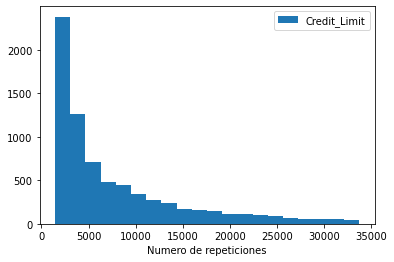

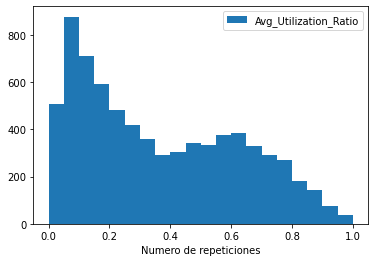

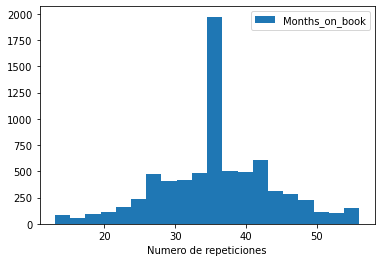

In [3]:
nodos = ['Credit_Limit','Avg_Utilization_Ratio','Months_on_book','Income_Category1']
for i in range(3):
    plt.hist(db[nodos[i]], bins=20, label= nodos[i])
    plt.legend()
    plt.xlabel('Numero de repeticiones')
    plt.show()
    

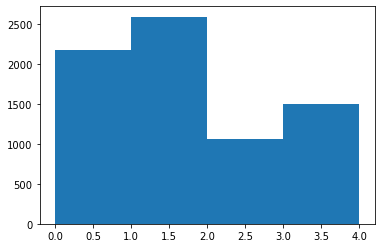

In [4]:
plt.hist(db['Income_Category1'],bins=4);

Histograma cuarto nodo: 

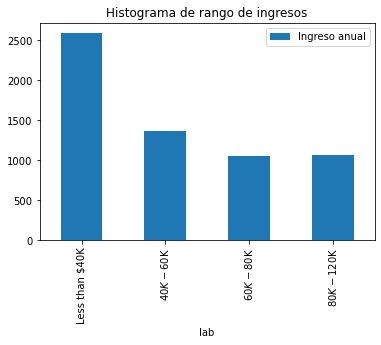

In [5]:
a = sum(db['Income_Category']=='Unknown')
b = sum(db['Income_Category']=='Less than $40K')
c = sum(db['Income_Category']=='$40K - $60K')
d = sum(db['Income_Category']=='$60K - $80K')
e = sum(db['Income_Category']=='$80K - $120K')
df = pd.DataFrame({'lab':['Less than $40K', '$40K - $60K' ,'$60K - $80K','$80K - $120K' ], 
                   'val':[b, c, d, e]})

df.plot.bar(x='lab', y='val',align='center',label = 'Ingreso anual')
plt.title('Histograma de rango de ingresos')
plt.show();

- A partir de este código decidimos separar los datos por cada nodo para que sean analizados y trabajados de una manera individual.

# Nodo 1 Limite de crédito: 
 
Podemos observar cual es el limite de crédito con el que es asignado cada uno de los clientes   

In [6]:
N_1 = np.array(db.Credit_Limit)

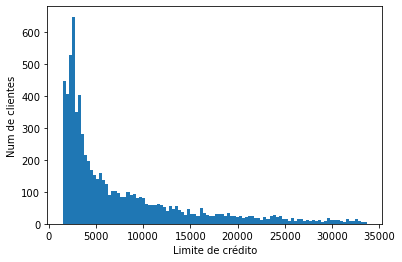

In [7]:
plt.hist(N_1,bins=100)
plt.xlabel('Limite de crédito')
plt.ylabel('Num de clientes')
plt.show()

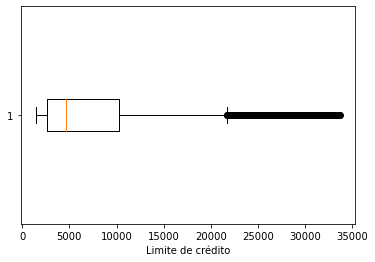

In [8]:
plt.boxplot(N_1, vert=False)
plt.xlabel('Limite de crédito');

### Primeros Insights: 
* Media 
* Max
* Min 


In [9]:
print('Tenemos una media de: ', round(N_1.mean()),'$')
print('El maximo crédito aprobado es de : ', N_1.max(),'$')
print('El minimo crédito aprobado es de : ', N_1.min(),'$')

Tenemos una media de:  7709.0 $
El maximo crédito aprobado es de :  33711.0 $
El minimo crédito aprobado es de :  1438.3 $


In [10]:
db_s = db.sample(n = 5000)
N_1s = np.array(db_s.Credit_Limit)


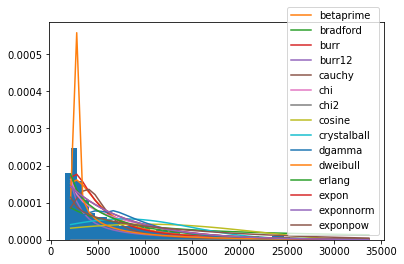

                 error
distribución          
erlang        0.232863
expon         0.340429
exponnorm     0.342014
betaprime     0.361441
burr          0.370518
chi           0.418315
exponpow      0.454455
burr12        0.483138
dgamma        0.527404
dweibull       0.58554
cauchy        0.614711
crystalball   0.628412
cosine        0.828826
chi2                 1
bradford       1.12099


In [11]:
prueba_dist(N_1s,50)


**Las que mejor se ajustaron fueron:** 

In [12]:
dist = ['genexpon','genhalflogistic','foldnorm','gausshyper','bradford']

[None, None, None, None]

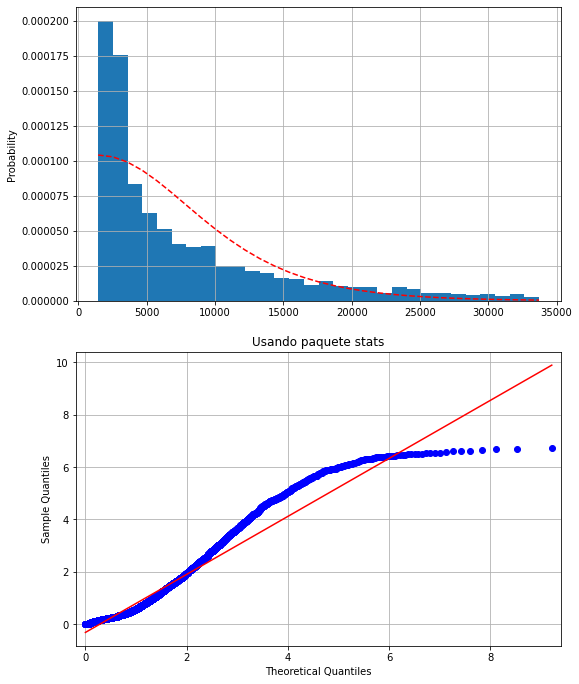

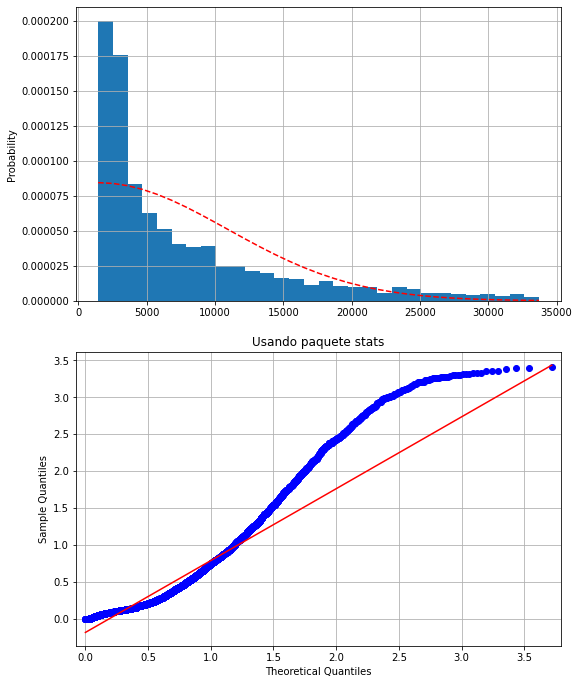

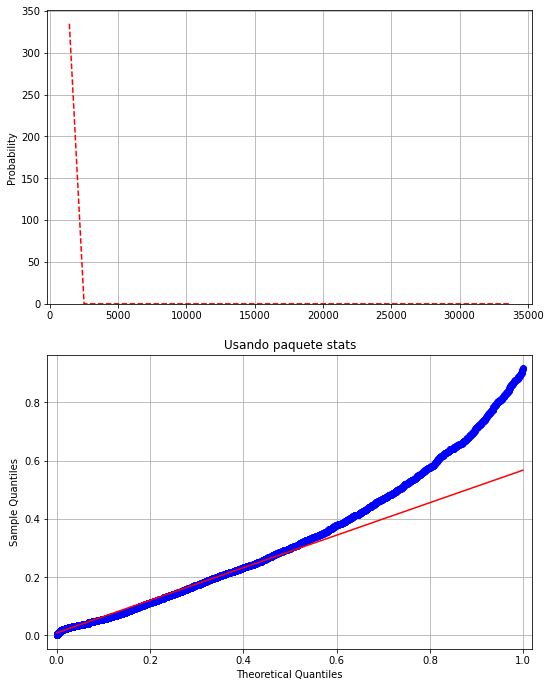

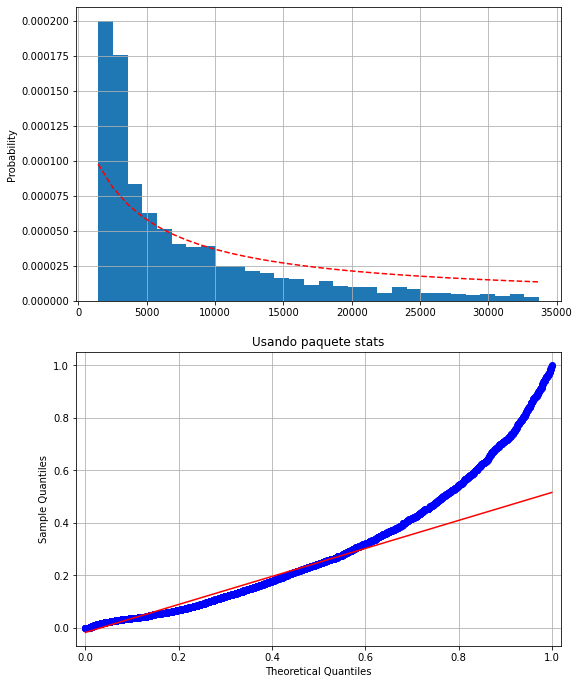

In [13]:
[q_q(N_1s, dist[i]) for i in range(1,len(dist))]

In [14]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0,50, 15)},
                    cv=20) # 20-fold cross-validation
grid.fit(N_1s[:, None])
print(grid.best_params_)

{'bandwidth': 46.42857142857143}


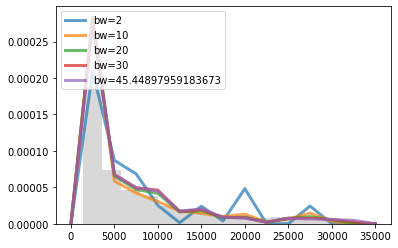

In [15]:
fig, ax = plt.subplots()
for bandwidth in [2,10,20,  30,45.44897959183673]:
    ax.plot(np.linspace(0,35000,15), kde_sklearn(N_1, np.linspace(0,35000,15), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(N_1s, 15, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

# Reducción de varianza y Montecarlo  

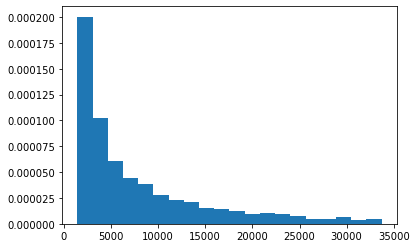

media mu =7773.642304, desviación estándar muestral =7153.883514
7709.295851588171 7120.933800149551


In [16]:
N=10000
f_1=kde_sklearn_mod(N_1s,  42.85714285714286)
proba = f_1(np.arange(1438.3,33711,.5))
f_acum = proba.cumsum()
# Reducción de varianza y Montecarlo


u = muestreo_est(N)
funcion2 = lambda u: (generador_var(f_acum, N_1s, N))
o=funcion2(u).values
a = [o[i] for i in range(0,len(o)) if o[i]>1]
np.mean(a)

# Reducción con método estratificado

complements=complementarios_1(N)
funcion2_1 = lambda u: (generador_var(f_acum, N_1s, N))
o_2=funcion2(u).values

# Reducción por complementario

J = 20
# Cantidad de particiones del histograma
    
    
y, x, _ = plt.hist(o_2, J, density=True)
plt.show()
x = x[:-1] # Se obvia el último valor de x 



mu = np.mean(a)
sigma = np.std(a)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))
print(N_1.mean(), N_1.std())
# Media y desviación estándar muestral

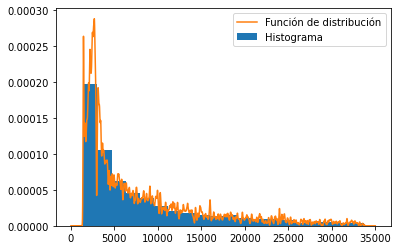

In [17]:
plt.hist(a, bins=20, density = True,label='Histograma')
plt.plot(np.arange(0,35000,10),f_1(np.arange(0,35000,10)),label='Función de distribución')

plt.legend()

plt.show()

In [18]:
# Prueba chi cuadrada 
dist = "foldnorm"
pi = getattr(st, dist).pdf(x, *getattr(st, dist).fit(a))

# Cálculo de la esperanza usando la expresión teórica
Ei = x*pi

# Cálculo teórico de la chi cuadrada
x2 = sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))

print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = len(getattr(st, dist).fit(a)) # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  5.642538868486105
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=5.642538868486106, pvalue=0.9986478336488311)
Estadístico de chi_cuadrado =  26.29622760486423
Media muestral =  7773.642303640408 
Desviación estándar muestral =  7153.883513817986


In [19]:
# Media simulando en 7709.240426 prueba de hipótesis

media = N_1s.mean()
sd = N_1s.std()
N = len(N_1s)

# Nivel de confianza
confianza = 0.95
X = N_1

# Hipótesis nula
media2 = 7709.240426
ho = st.ttest_1samp(X, media2)# Realizamos la prueba de hipótesis para H0= mu=media2
print('La prueba de hipótesis arroja como resultado\n',ho)
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))# Calculamos el estadístico normalizado
print('Cálculo del estadístico de prueba teórico=', t)
confianza_ph = 0.05# Cálculo de la región de rechazo
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

La prueba de hipótesis arroja como resultado
 Ttest_1sampResult(statistic=0.0006651567650131455, pvalue=0.9994692998933286)
Cálculo del estadístico de prueba teórico= 0.0005503745765186901
Región de rechazo = (t<-0.8351962816243441) U (t>0.8351962816243441)


In [20]:
# Nivel de confianza, y su intérvalo.
# Parámetros de los datos reales
confianza = .95
media = N_1.mean()
sd = N_1.std()

# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(N_1)-1, loc=np.mean(N_1), scale=st.sem(N_1))

print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(a))
np.mean(N_1)

Con una confianza de 0.95 la media estará en el intervalo t,
 (7545.950653184974, 7872.641049991368)
Media calculada 7773.642303640408


7709.295851588171

In [ ]:
## Método de reducción de varianza: números complementarios
ri = np.random.rand(N)
ri_c = 1-ri 
U1= f_u2_n2(ri)
U2= f_u2_n2(ri_c)

m4 = (U1.mean()+U2.mean())/2

print('Complementario =',np.mean(m4))

# Comentarios y conclusiones del nodo1: 

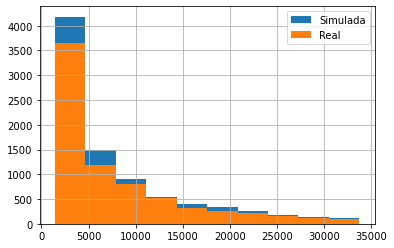

In [21]:
plt.hist(a,label='Simulada');
plt.hist(N_1, label='Real');
plt.legend()
plt.grid()
plt.show()

Generamos una distribucción que como podemos observar en el histograma, simula de manera adecuada el comportamiento del crédito asignado a cada cliente. Lo que nos permitira tener una simulación mas real a la hora de determinar su nivel de tarjeta de crédito. 

tabien podemos decir que la media de nuetra simulación es precisa dado que se encuentra dentro del intervalo de confianza 

# Nodo 2 Porcentaje de uso de crédito:


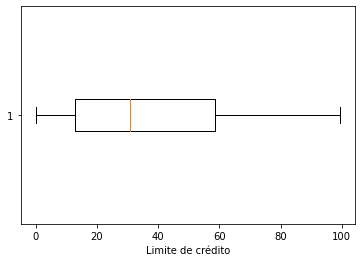

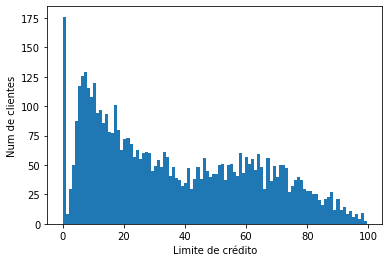

In [22]:
N_2 = db_s['Avg_Utilization_Ratio']*100
plt.boxplot(N_2, vert=False)
plt.xlabel('Limite de crédito')
plt.show();

plt.hist(N_2,bins=100)
plt.xlabel('Limite de crédito')
plt.ylabel('Num de clientes')
plt.show();

In [23]:
print('Tenemos una media de: ', N_2.mean(),'%')
print('El maximo crédito utilizado es de : ', N_2.max(),'%')
print('El minimo crédito utilizado es de : ', N_2.min(),'%')

Tenemos una media de:  36.36508000000007 %
El maximo crédito utilizado es de :  99.5 %
El minimo crédito utilizado es de :  0.0 %


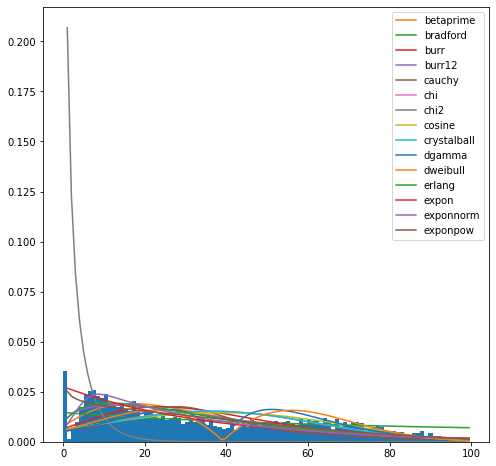

                 error
distribución          
dweibull      0.377237
cosine        0.393714
dgamma        0.415244
exponnorm      0.42416
burr12        0.437817
crystalball   0.438146
chi           0.440322
erlang         0.44137
betaprime     0.450119
exponpow      0.454222
burr          0.454696
expon         0.513083
cauchy        0.526548
bradford      0.794873
chi2           1.88932


In [24]:
plt.figure(figsize=(8,8))
prueba_dist(N_2,100)

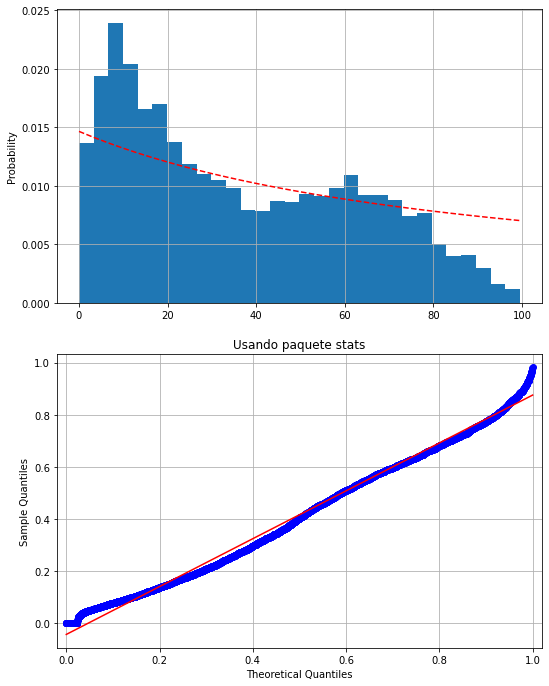

In [25]:
q_q(N_2, 'bradford')

In [26]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 100, 80)},
                    cv=20) # 20-fold cross-validation
grid.fit(N_2[:, None])
print(grid.best_params_)

{'bandwidth': 1.2658227848101267}


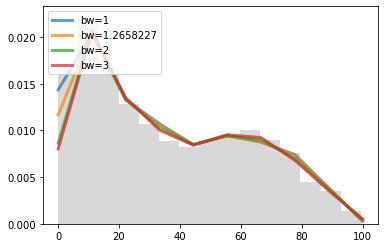

In [27]:
fig, ax = plt.subplots()
for bandwidth in [1,1.2658227,2,3]:
    ax.plot(np.linspace(0,100,10), kde_sklearn(N_2, np.linspace(0,100,10), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(N_2, 15, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

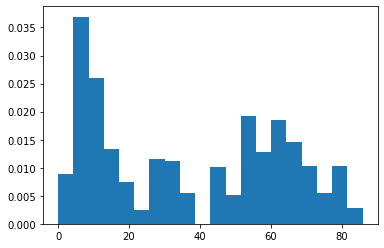

media mu =36.874100, desviación estándar muestral =26.088732
36.36508000000007 26.15416052210671


In [88]:
# Reducción de varianza y Montecarlo
N=10000

f_1=kde_sklearn_mod(N_2,1.2658227)
proba = f_1(np.arange(0,100,.5))
f_acum = proba.cumsum()

# Reducción con método estratificado
u = muestreo_est(N)
funcion2 = lambda u: (generador_var(f_acum, N_2, N))
o=funcion2(u).values

# Reducción por complementarios

complements=complementarios_1(N)
funcion2_1 = lambda u: (generador_var(f_acum, N_2, N))
o_2=funcion2(u).values

J = 20  # Cantidad de particiones del histograma

y, x, _ = plt.hist(o, J, density=True)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(o)
sigma = np.std(o)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))
print(N_2.mean(), N_2.std())

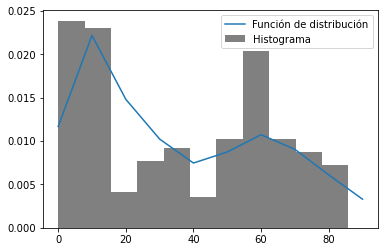

In [89]:
# Comparamos el histograma de "o" (10000 simulaciones del ataque especial, en función de su distribución de probabilidad)
plt.hist(o, bins=11, density = True, color = 'gray',label='Histograma')
plt.plot(np.arange(0,100,10),f_1(np.arange(0,100,10)),label='Función de distribución')
plt.legend()
plt.show()

In [90]:
# Prueba chi cuadrada 
dist = "bradford"
pi = getattr(st, dist).pdf(x, *getattr(st, dist).fit(o))

# Cálculo de la esperanza usando la expresión teórica
x[0]=1 # Debido a que tenemos cero en el primer valor nos daría inf 
Ei = x*pi

# Cálculo teórico de la chi cuadrada
x2 = sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))

print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = len(getattr(st, dist).fit(o)) # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  7.717111062267271
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=7.7171110622672705, pvalue=0.9892978692764047)
Estadístico de chi_cuadrado =  26.29622760486423
Media muestral =  36.8741 
Desviación estándar muestral =  26.088731881599763


In [91]:
# Media simulando en 35.405580 prueba de hipótesis

media = N_2.mean()
sd = N_2.std()
N = len(N_2)

# Nivel de confianza
confianza = 0.95
N_2 = db_s['Avg_Utilization_Ratio']*100
X = N_2

# Hipótesis nula
media2 = 35.405580
ho = st.ttest_1samp(X, media2)# Realizamos la prueba de hipótesis para H0= mu=media2
print('La prueba de hipótesis arroja como resultado\n',ho)
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))# Calculamos el estadístico normalizado
print('Cálculo del estadístico de prueba teórico=', t)
confianza_ph = 0.05# Cálculo de la región de rechazo
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

La prueba de hipótesis arroja como resultado
 Ttest_1sampResult(statistic=2.5941148291684755, pvalue=0.009511157701751066)
Cálculo del estadístico de prueba teórico= 2.59437427956977
Región de rechazo = (t<-0.8351962816243441) U (t>0.8351962816243441)


In [92]:
# Nivel de confianza, y su intérvalo.
# Parámetros de los datos reales
confianza = .95
media = N_2.mean()
sd = N_2.std()

# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(N_2)-1, loc=np.mean(N_2), scale=st.sem(N_2))

print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(o))
np.mean(N_2)

Con una confianza de 0.95 la media estará en el intervalo t,
 (35.63996141221778, 37.09019858778236)
Media calculada 36.8741


36.36508000000007

No handles with labels found to put in legend.


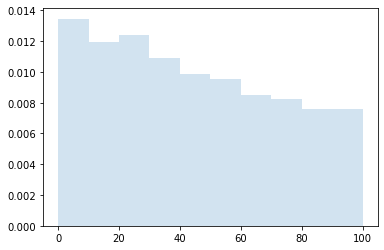

In [142]:
from scipy.stats import bradford
fig, ax = plt.subplots(1, 1)
c =1
r = bradford.rvs(c, size=5000)
r = r*100
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

# Conclusiones del Nodo 2:

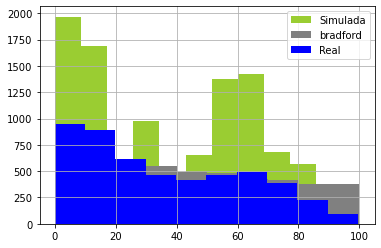

In [143]:
from scipy.stats import bradford
plt.hist(o,label='Simulada',color='yellowgreen');
plt.hist(r,label='bradford',color='gray')
plt.hist(N_2, label='Real',color='blue');
ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
plt.legend()
plt.grid()
plt.show()

Podemos observar que nuestro modelo sigue la tendencia y distribuye de una manera aproximada a la real, lo cual nos permitira en base a su uso de crédito determinar su nivel de crédito

Manteniendo la media del modelo en 35% con un nivel de confianza del 95% 


In [146]:
Simulacion_N2 = r

# Nodo 3 Meses de relacción con el banco 

In [147]:
N_3 = db_s['Months_on_book']

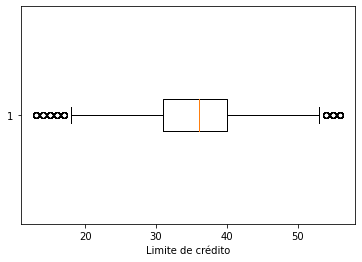

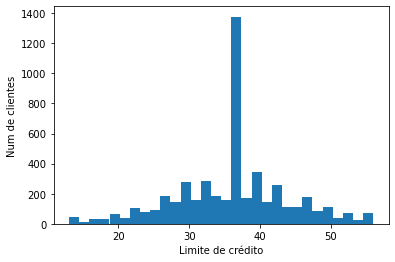

In [148]:
plt.boxplot(N_3, vert=False)
plt.xlabel('Limite de crédito')
plt.show();

plt.hist(N_3,bins=30)
plt.xlabel('Limite de crédito')
plt.ylabel('Num de clientes')
plt.show();

In [149]:
print('Tenemos una media de: ', N_3.mean(),'Meses')
print('El maximo es de : ', N_3.max(),'Meses')
print('El minimo es de : ', N_3.min(),'Meses')

Tenemos una media de:  35.8728 Meses
El maximo es de :  56 Meses
El minimo es de :  13 Meses


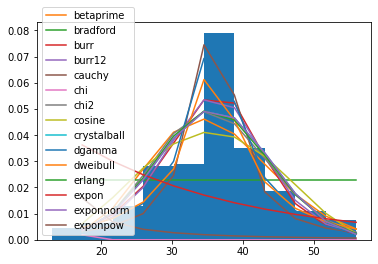

                 error
distribución          
dweibull       0.36165
dgamma        0.410916
burr12        0.413306
exponnorm     0.426089
crystalball   0.426094
burr          0.428863
erlang        0.441022
chi2          0.455206
betaprime     0.464553
cauchy        0.497894
cosine        0.524859
chi           0.956651
exponpow       0.99529
bradford       1.23018
expon          1.48738


In [150]:
prueba_dist(N_3,10)

In [151]:
Distribuciones_N3 = ['erlang','bradford','crystalball','burr12']


[None, None, None, None]

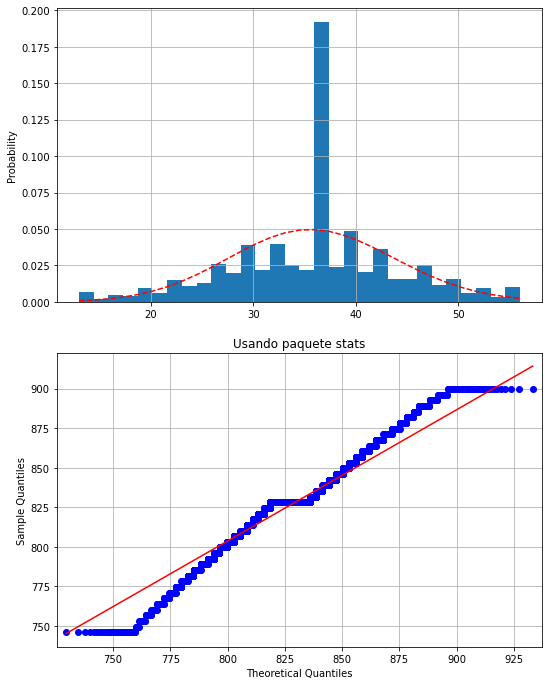

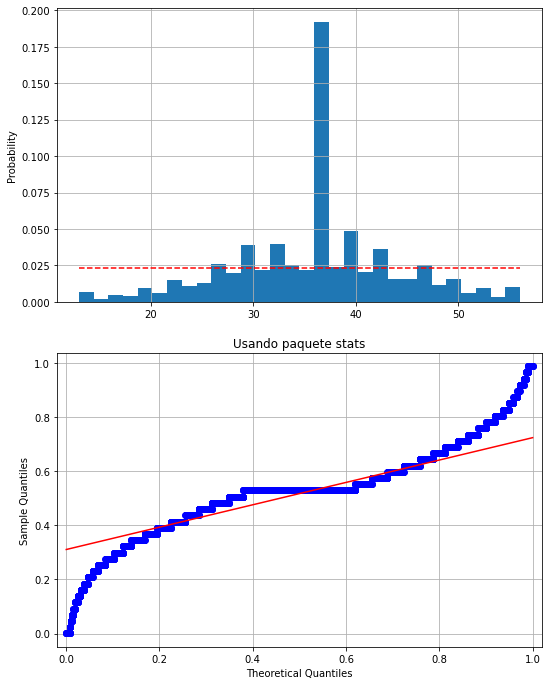

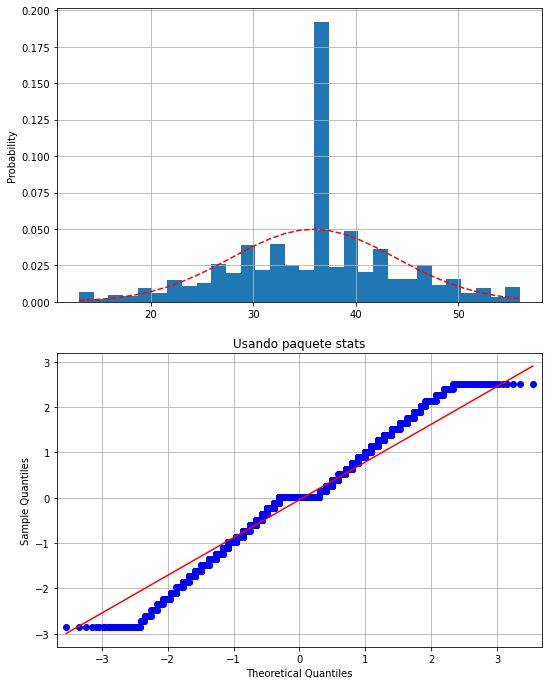

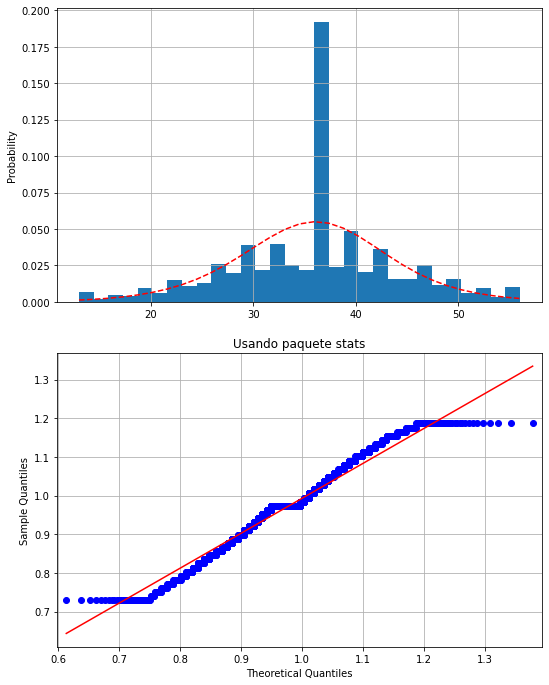

In [152]:
[q_q(N_3,Distribuciones_N3[i]) for i in range(0,len(Distribuciones_N3))]

In [153]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 60, 50)},
                    cv=20) # 20-fold cross-validation
grid.fit(N_3[:, None])
print(grid.best_params_)

{'bandwidth': 1.2244897959183674}


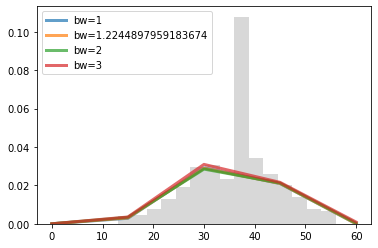

In [154]:
fig, ax = plt.subplots()
for bandwidth in [1,1.2244897959183674,2,3]:
    ax.plot(np.linspace(0,60,5), kde_sklearn(N_3, np.linspace(0,60,5), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(N_3, 15, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

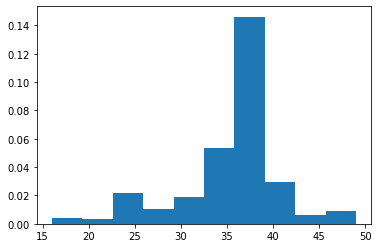

media mu =35.388600, desviación estándar muestral =5.399703
35.8728 8.015626626411885


In [155]:
# Reducción de varianza y Montecarlo
N=10000

f_1=kde_sklearn_mod(N_3,1.2244897959183674)
proba = f_1(np.arange(0,60,.5))
f_acum = proba.cumsum()

# Reducción con método estratificado
u = muestreo_est(N)
funcion2 = lambda u: (generador_var(f_acum, N_3, N))
o=funcion2(u).values

# Reducción por complementarios

complements=complementarios_1(N)
funcion2_1 = lambda u: (generador_var(f_acum, N_3, N))
o_2=funcion2(u).values

# 

J = 10  # Cantidad de particiones del histograma

y, x, _ = plt.hist(o, J, density=True)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(o)
sigma = np.std(o)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))
print(N_3.mean(), N_3.std())

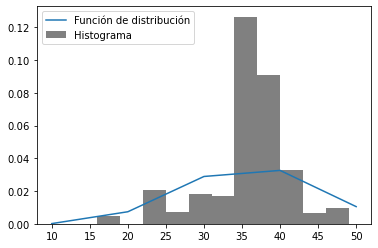

In [157]:
# Comparamos el histograma de "o" (10000 simulaciones del ataque especial, en función de su distribución de probabilidad)
plt.hist(o, bins=11, density = True, color = 'gray',label='Histograma')
plt.plot(np.arange(10,60,10),f_1(np.arange(10,60,10)),label='Función de distribución')
plt.legend()
plt.show()

In [156]:
# Prueba chi cuadrada 
dist = "crystalball"
pi = getattr(st, dist).pdf(x, *getattr(st, dist).fit(o))

# Cálculo de la esperanza usando la expresión teórica
x[0]=1 # Debido a que tenemos cero en el primer valor nos daría inf 
Ei = x*pi

# Cálculo teórico de la chi cuadrada
x2 = sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))

print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = len(getattr(st, dist).fit(o)) # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  10.097231680771346
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=10.097231680771346, pvalue=0.34267128777499267)
Estadístico de chi_cuadrado =  11.070497693516351
Media muestral =  35.3886 
Desviación estándar muestral =  5.399702773301509


In [158]:
# Media simulando en 35.388600 prueba de hipótesis

media = N_3.mean()
sd = N_3.std()
N = len(N_3)

# Nivel de confianza
confianza = 0.95
X = N_3

# Hipótesis nula
media2 = 35.388600
ho = st.ttest_1samp(X, media2)# Realizamos la prueba de hipótesis para H0= mu=media2
print('La prueba de hipótesis arroja como resultado\n',ho)
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))# Calculamos el estadístico normalizado
print('Cálculo del estadístico de prueba teórico=', t)
confianza_ph = 0.05# Cálculo de la región de rechazo
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

La prueba de hipótesis arroja como resultado
 Ttest_1sampResult(statistic=4.27142030695848, pvalue=1.9783771588018447e-05)
Cálculo del estadístico de prueba teórico= 4.271847513071149
Región de rechazo = (t<-0.8351962816243441) U (t>0.8351962816243441)


In [159]:
# Nivel de confianza, y su intérvalo.
# Parámetros de los datos reales
confianza = .95
media = N_3.mean()
sd = N_3.std()

# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(N_3)-1, loc=np.mean(N_3), scale=st.sem(N_3))

print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(o))
np.mean(N_3)

Con una confianza de 0.95 la media estará en el intervalo t,
 (35.65056844129173, 36.095031558708264)
Media calculada 35.3886


35.8728

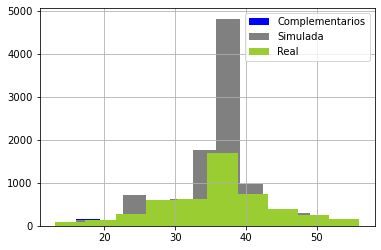

In [248]:
plt.hist(o_2,label='Complementarios',color='Blue')
plt.hist(o,label='Simulada',color='gray')
plt.hist(N_3,label='Real',color='yellowgreen')
plt.legend()
plt.grid()
plt.show()

# Conclusiones Nodo 3 

In [249]:
Simulacion_Nodo3 = o

# Nodo 4 Ingreso Anual

In [250]:
N_4_s =db['Income_Category1']
N_4 = db['Income_Category2']

In [251]:
Diccionario_N4 = {0:'Unknown and Less than $40K',1:'$40K - $60K',2:'$60K - $80K',3:'$80K - $120K',4:'$120K +'}
Diccionario_N4

{0: 'Unknown and Less than $40K',
 1: '$40K - $60K',
 2: '$60K - $80K',
 3: '$80K - $120K',
 4: '$120K +'}

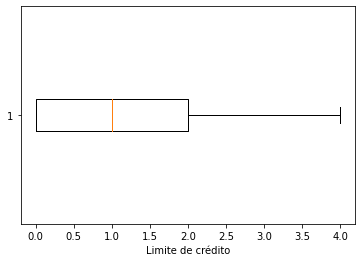

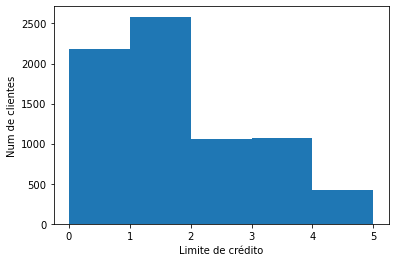

In [252]:
plt.boxplot(N_4_s, vert=False)
plt.xlabel('Limite de crédito')
plt.show();

plt.hist(N_4,bins=5,density=False)
plt.xlabel('Limite de crédito')
plt.ylabel('Num de clientes')
plt.show();

In [234]:
print('El rango de ingresos anuales que mas hay es de: ', Diccionario_N4[N_4_s.mode()[0]])
print('El rango de ingresos anuales que menos hay es de: ', Diccionario_N4[4])

El rango de ingresos anuales que mas hay es de:  $40K - $60K
El rango de ingresos anuales que menos hay es de:  $120K +


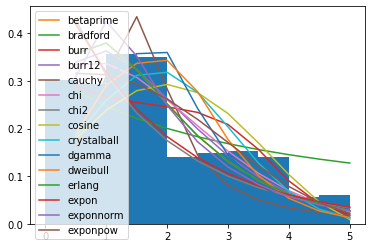

                 error
distribución          
exponpow      0.274257
chi           0.277633
burr12         0.28909
erlang        0.305414
betaprime     0.305771
exponnorm     0.309855
burr          0.312627
expon         0.319933
chi2          0.346118
dgamma        0.364175
dweibull      0.389225
cosine        0.391867
crystalball   0.400161
bradford      0.409266
cauchy        0.414776


In [253]:
prueba_dist(N_4,10)

In [256]:
Distribuciones_N4 = ['exponpow','chi','burr','bradford']

[None, None, None, None]

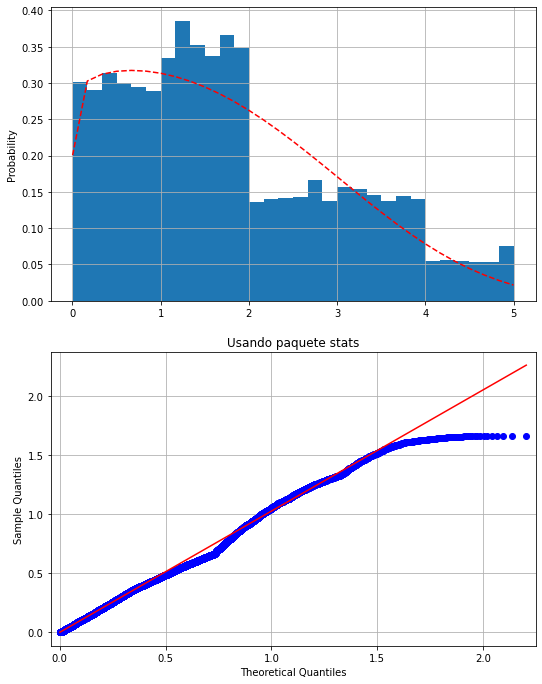

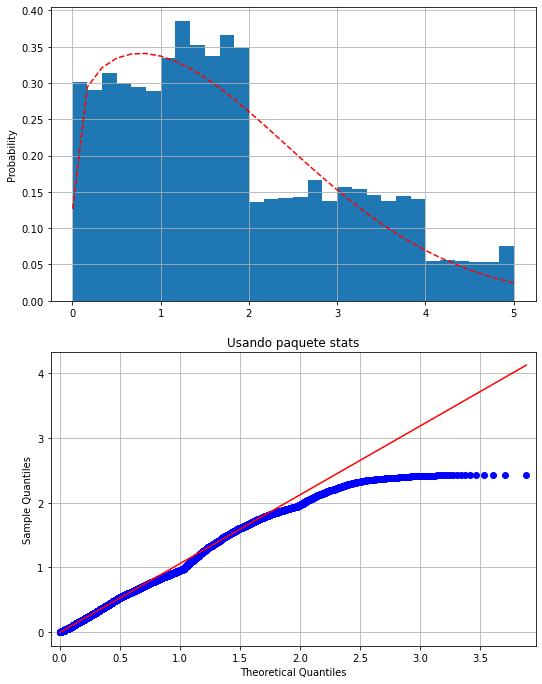

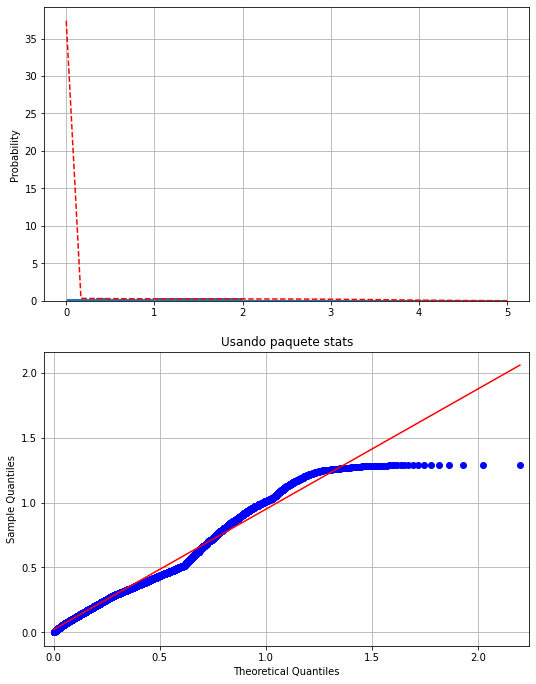

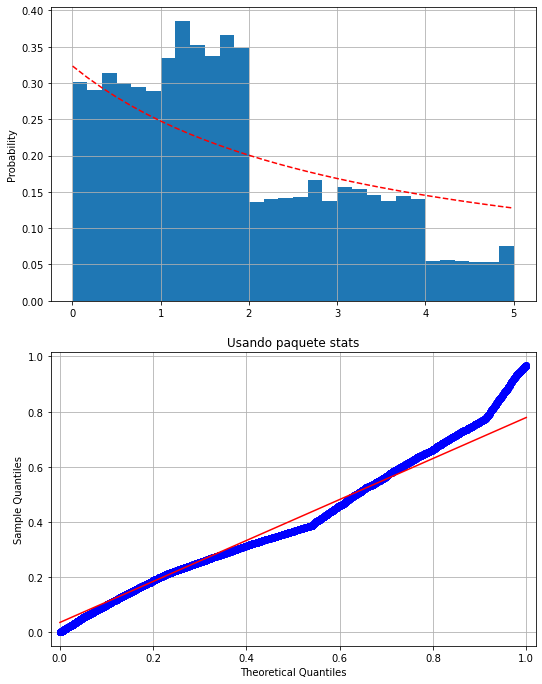

In [257]:
[q_q(N_4,Distribuciones_N4[i]) for i in range(0,len(Distribuciones_N4))]

In [258]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0, 5, 20)},
                    cv=20) # 20-fold cross-validation
grid.fit(N_4[:, None])
print(grid.best_params_)

{'bandwidth': 0.2631578947368421}


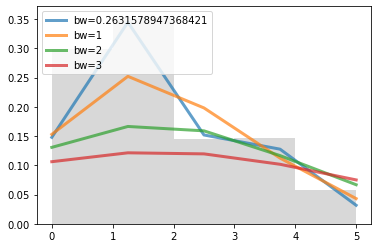

In [274]:
fig, ax = plt.subplots()
for bandwidth in [0.2631578947368421,1,2,3]:
    ax.plot(np.linspace(0,5,5), kde_sklearn(N_4, np.linspace(0,5,5), bandwidth=bandwidth),
            label='bw={0}'.format(bandwidth), linewidth=3, alpha=0.7)
ax.hist(N_4, 5, fc='gray', histtype='stepfilled', alpha=0.3, density=True)
ax.legend(loc='upper left')

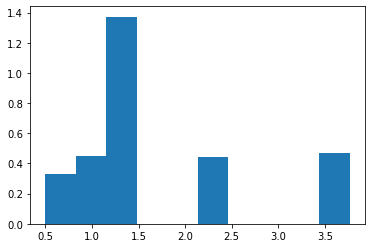

media mu =1.681551, desviación estándar muestral =1.016669
1.8137841945943334 1.2391338060771029


In [301]:
# Reducción de varianza y Montecarlo
N=10000

f_1=kde_sklearn_mod(N_4,0.2631578947368421)
proba = f_1(np.arange(0,5,.001))
f_acum = proba.cumsum()

# Reducción con método estratificado
u = muestreo_est(N)
funcion2 = lambda u: (generador_var(f_acum, N_4, N))
o=funcion2(u).values

# Reducción por complementarios

complements=complementarios_1(N)
funcion2_1 = lambda u: (generador_var(f_acum, N_4, N))
o_2=funcion2(u).values

J = 10  # Cantidad de particiones del histograma

y, x, _ = plt.hist(o, J, density=True)
plt.show()

# Se obvia el último valor de x para obtener exactamente J muestras de x
x = x[:-1] 

# Media y desviación estándar muestral
mu = np.mean(o)
sigma = np.std(o)
print('media mu =%f, desviación estándar muestral =%f'%(mu,sigma))
print(N_4.mean(), N_4.std())

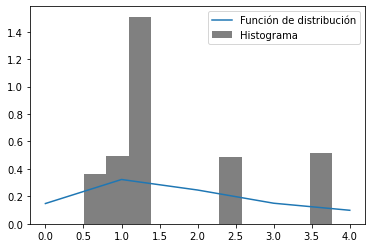

In [302]:
# Comparamos el histograma de "o" (10000 simulaciones del ataque especial, en función de su distribución de probabilidad)
plt.hist(o, bins=11, density = True, color = 'gray',label='Histograma')
plt.plot(np.arange(0,5,1),f_1(np.arange(0,5,1)),label='Función de distribución')
plt.legend()
plt.show()

In [303]:
# Prueba chi cuadrada 
dist = "bradford"
pi = getattr(st, dist).pdf(x, *getattr(st, dist).fit(o))

# Cálculo de la esperanza usando la expresión teórica
x[0]=1 # Debido a que tenemos cero en el primer valor nos daría inf 
Ei = x*pi

# Cálculo teórico de la chi cuadrada
x2 = sum(list(map(lambda Ei, obs_i:(obs_i - Ei)**2 / Ei, Ei, y)))

print('Valor de chi cuadrado teorico  = ', x2)

# Cálculo usando la librería estadística de la chi cuadrada
X2 = st.chisquare(y, Ei)
print('Valor de chi cuadrado librería = ', X2)

# Cálculo de Grados de libertad del estadístico
p = len(getattr(st, dist).fit(o)) # Parámetros estimados con los datos
m = J-p-1 # grados de libertad

Chi_est = st.chi2.ppf(q=0.95, df=m)
print('Estadístico de chi_cuadrado = ', Chi_est)
print('Media muestral = ', mu, '\nDesviación estándar muestral = ', sigma)

Valor de chi cuadrado teorico  =  4.57000363709945
Valor de chi cuadrado librería =  Power_divergenceResult(statistic=4.57000363709945, pvalue=0.8700677215371109)
Estadístico de chi_cuadrado =  12.591587243743977
Media muestral =  1.6815511476265999 
Desviación estándar muestral =  1.0166694739753404


In [305]:
# Media simulando en 1.776913 prueba de hipótesis

media = N_4.mean()
sd = N_4.std()
N = len(N_4)

# Nivel de confianza
confianza = 0.95
X = N_4

# Hipótesis nula
media2 = 1.681551
ho = st.ttest_1samp(X, media2)# Realizamos la prueba de hipótesis para H0= mu=media2
print('La prueba de hipótesis arroja como resultado\n',ho)
t = (np.mean(X) - media2)/(np.std(X) / np.sqrt(N))# Calculamos el estadístico normalizado
print('Cálculo del estadístico de prueba teórico=', t)
confianza_ph = 0.05# Cálculo de la región de rechazo
cuantil = st.t(N-1).cdf(1-confianza_ph/2)
print(f'Región de rechazo = (t<{-cuantil}) U (t>{cuantil})')

La prueba de hipótesis arroja como resultado
 Ttest_1sampResult(statistic=9.120164395744325, pvalue=9.542233884091044e-20)
Cálculo del estadístico de prueba teórico= 9.120788786557181
Región de rechazo = (t<-0.8352037232010012) U (t>0.8352037232010012)


In [308]:
# Nivel de confianza, y su intérvalo.
# Parámetros de los datos reales
confianza = .95
media = N_4.mean()
sd = N_4.std()

# Intervalo de confianza usando t-student
i1 = st.t.interval(confianza, len(N_4)-1, loc=np.mean(N_4), scale=st.sem(N_4))

print('Con una confianza de %2.2f la media estará en el intervalo t,\n %s' %(confianza,i1))
print('Media calculada' ,np.mean(o))
np.mean(N_4)

Con una confianza de 0.95 la media estará en el intervalo t,
 (1.7853619810564607, 1.842206408132206)
Media calculada 1.6815511476265999


1.8137841945943334

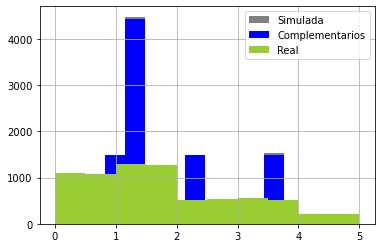

In [310]:
plt.hist(o,label='Simulada',color='gray')
plt.hist(o_2,label='Complementarios',color='Blue')
plt.hist(N_4,label='Real',color='yellowgreen')
plt.legend()
plt.grid()
plt.show()

# Conclusiones nodo 4